**Data Mining and Machine Learning - Assignment 1**

# Question 1 - NOx Study

Modelling of $LNOx$ concentration as function of other variables 

In [84]:
# Import of used libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import numpy as np

In [59]:
# Import of the dataset
q1_pd = pd.read_csv('NOxEmissions.csv')
q1_pd

,rownames,julday,LNOx,LNOxEm,sqrtWS
0,193,373,4.457250,5.536489,0.856446
1,194,373,4.151827,5.513000,1.016612
2,195,373,3.834061,4.886994,1.095445
3,196,373,4.172848,5.138912,1.354068
4,197,373,4.322807,5.666518,1.204159
...,...,...,...,...,...
8083,8779,730,5.000585,6.730993,1.396424
8084,8780,730,4.669552,6.165086,1.466288
8085,8781,730,4.380776,5.855493,1.559808
8086,8782,730,4.284276,5.691445,1.449138


## (a) - Data Pre-processing

In the pre-processing we want to address data quality problems like Incorrect Data, Missing Values, duplicate data, outliers... 

- **Missing data:** No missing data found in the dataset
- **Duplicates:** No duplicates were found.

In [60]:
# (a) - Pre-processing

# Check if missing/duplicated/Invalid data is present in the dataset

## Missing data
print(f"Number of missing data: {q1_pd.isnull().sum().sum()}")
## Duplicated data
print(f"Number of duplicated data: {q1_pd.duplicated().sum()}")

## Statistical Summary
print(f"===Statistical Summary===\n{q1_pd.describe()}")


Number of missing data: 0
Number of duplicated data: 0
===Statistical Summary===
          rownames       julday         LNOx       LNOxEm       sqrtWS
count  8088.000000  8088.000000  8088.000000  8088.000000  8088.000000
mean   4597.584570   556.078882     4.378691     7.338244     1.365253
std    2464.686179   102.706509     0.937389     1.016658     0.466280
min     193.000000   373.000000    -0.105361     4.157866     0.316228
25%    2507.750000   469.000000     3.891820     6.514982     1.016612
50%    4681.500000   560.000000     4.497028     7.692495     1.284523
75%    6709.250000   644.000000     5.012134     8.239159     1.648181
max    8783.000000   730.000000     6.576121     8.600040     3.624017


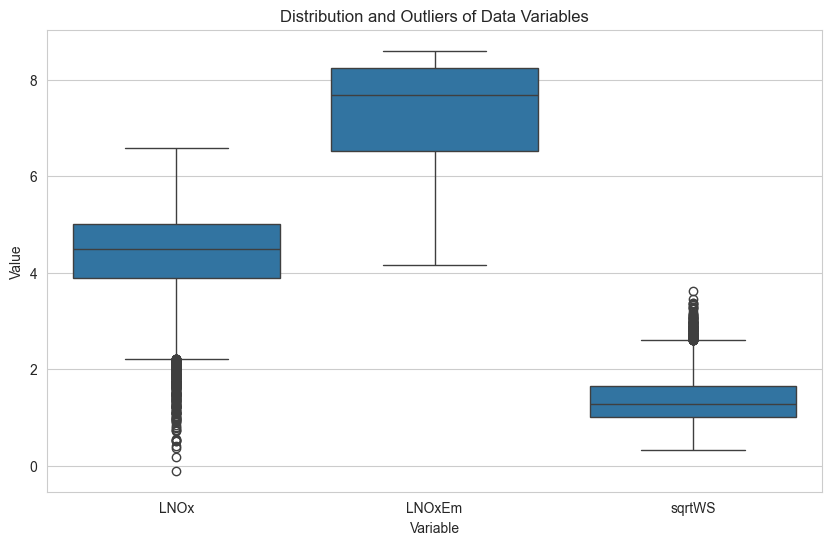

In [61]:
# Check for outliers

melted_data = pd.melt(q1_pd, value_vars=['LNOx', 'LNOxEm', 'sqrtWS'], var_name='Variable', value_name='Value')
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6)) 
boxplot = sns.boxplot(x='Variable', y='Value', data=melted_data)
boxplot.set_title('Distribution and Outliers of Data Variables')
boxplot.set_ylabel('Value')
boxplot.set_xlabel('Variable')

plt.show()

## (b) - Distribution of LNOx variable

To describe the distribution of the $LNOx$ variable we are going to use descriptive statistics indicators along with diagrams for visualization.

$LNOx$ appears to have a normal distribution with a significant number of outliers on the left side (as shown by the previous box-plot.
Also a left (negative) skew is evident in the graph and by using the descriptive statistics. 

Mean: 4.378690810185019
Median: 4.49702802736839
Standard Deviation: 0.937388582502527
Variance: 0.8786973546060968
Range: 6.681481834658996
Skewness: -0.8244320335510329
Kurtosis: 1.1307787937580986


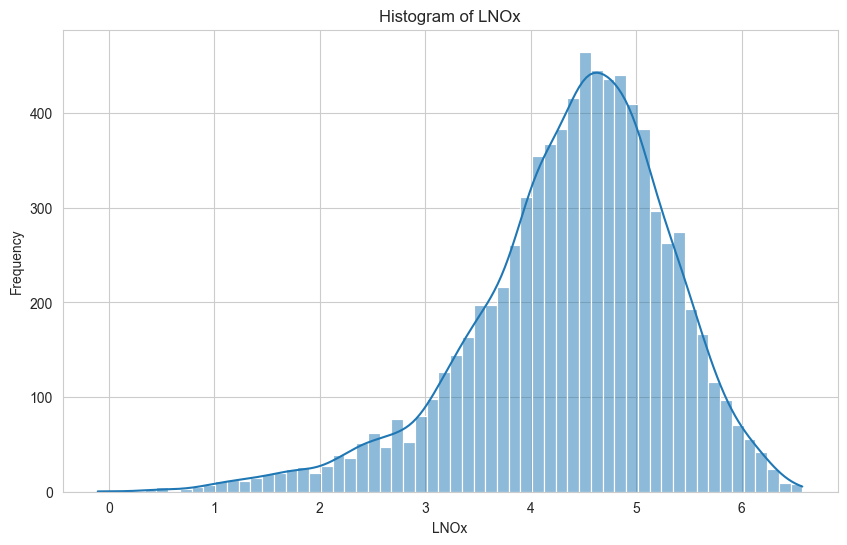

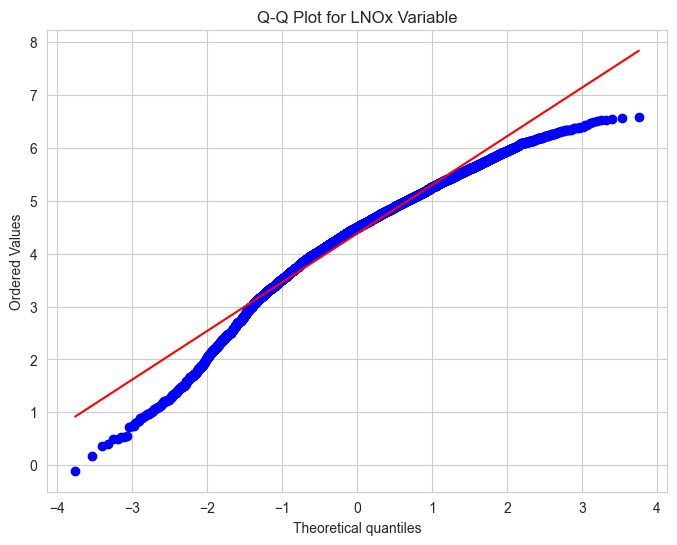

In [62]:
# (b) - LNOx distribution

lnox = q1_pd['LNOx']

## Descriptive Stats
range_lnox = lnox.max() - lnox.min()
print(f"Mean: {lnox.mean()}\nMedian: {lnox.median()}\nStandard Deviation: {lnox.std()}\nVariance: {lnox.var()}\nRange: {range_lnox}\nSkewness: {lnox.skew()}\nKurtosis: {lnox.kurt()}")

## Histogram plot
plt.figure(figsize=(10, 6))
sns.histplot(q1_pd['LNOx'], kde=True)
plt.title('Histogram of LNOx')
plt.xlabel('LNOx')
plt.ylabel('Frequency')
plt.show()

# Q-Q plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
stats.probplot(q1_pd['LNOx'], dist="norm", plot=ax)
ax.set_title("Q-Q Plot for LNOx Variable")
plt.show()

## (c) - Linear Model of LNOx as fn. of LNOxEm, sqrtWS

The $LNOx$ linear model is fitted below using a multiple linear regression, $LNOx$ is the dependent variable, $LNOxEm$ and $sqrtWS$ are the independent variables as requested by the question.

The OLS-regression results from the model shows that:

- $R^2 = 0.663$, that means that the independent variables can explain about $66\%$ of variability of $LNOx$.
- The coefficients of the independent variables explains:
    - $LNOxEm$: When this variables increase, $LNOx$ **increases** too by a factor of $\approx 0.06$.
    - $sqrtWS$: When the square root of wind speed increases, $LNOx$ get **decreased** by a factor of $\approx 1.01$


In [63]:
# (c) - LNOx linear model 

X = q1_pd[['LNOxEm', 'sqrtWS']]
X = sm.add_constant(X)
y = q1_pd['LNOx']
model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   LNOx   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     7952.
Date:                Thu, 11 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:01:27   Log-Likelihood:                -6554.7
No. Observations:                8088   AIC:                         1.312e+04
Df Residuals:                    8085   BIC:                         1.314e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0619      0.046     23.097      0.000       0.972       1.152
LNOxEm         0.6414      0.006    107.092      0.000       0.630       0.653
sqrtWS        -1.0182      0.013    -77.969      0.000      -1.044      -0.993
==============================================================================
Omnibus:                       28.937   Durbin-Watson:                   0.497
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.943
Skew:                          -0.115   Prob(JB):                     1.91e-07
Kurtosis:                       3.198   Cond. No.                         58.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## (d) - Relationship between dependent and independent variables

In the Linear Regression model created above, we analyzed how the concentration of nitrogen close to a motorway ($LNOx$, the dependent variable) is influenced by:

- The emission of $NOx$ of cars on the motorway ($LNOxEm$)
- The square root of wind speed ($sqrtWS$)

The results of the model shows that both (independent) variables are significant in determining the concentration of $NOx$. An increase of the wind speed ($sqrtWS$) tends to lower the concentration of $NOx$, probably because it would disperse the $NOx$ present in the air. 
On the other hand $LNOxEm$ has a positive impact on the concentration of $NOx$, this probably means that when the volume of emissions of car in the motorway increases so does the $NOx$ concentration close the motorway. However, this affects the concentration of nitrogen less than the wind does.

## (e) - Prediction of LNOx given the indp. variables values.

Given the value of the emission of cars in the motorway ($LNOxEm = 7.5$) and wind speed ($sqrtWS = 1.3$) the estimated value for the concentration of pollution close to the motorway is $LNOx \approx 4.55$. This means that given the amount of pollution the cars are making ($7.5$) and how fast the wind is blowing ($1.3$) the air pollution is expected to be around $4.55$.

By consulting the data available the prediction in close to the average concentration of pollution, suggesting that the prediction is within reasonable ranges.

The predicted LNOx value is: 4.55


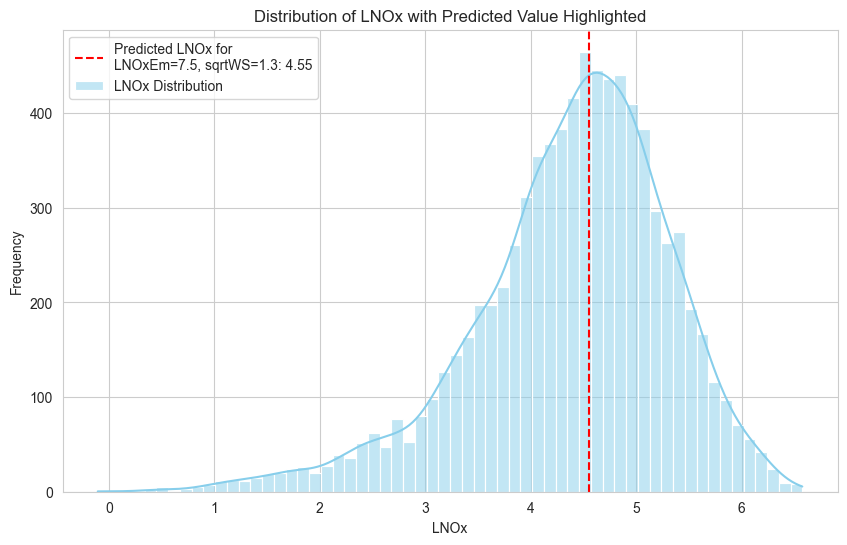

In [64]:
# (e) - prediction using pre-defined values

# LNOxEm = 7.5, sqrtWS = 1.3
new_data = pd.DataFrame({'const': 1, 'LNOxEm': [7.5], 'sqrtWS': [1.3]})
predicted_LNOx = model.predict(new_data)

print(f"The predicted LNOx value is: {predicted_LNOx[0]:.2f}")

# Distribution + predicted value
plt.figure(figsize=(10, 6))
sns.histplot(q1_pd['LNOx'], kde=True, color="skyblue", label='LNOx Distribution')
plt.axvline(x=predicted_LNOx[0], color='red', linestyle='--', label=f'Predicted LNOx for\nLNOxEm=7.5, sqrtWS=1.3: {predicted_LNOx.iloc[0]:.2f}')
plt.legend()
plt.title('Distribution of LNOx with Predicted Value Highlighted')
plt.xlabel('LNOx')
plt.ylabel('Frequency')
plt.show()

# Question 2 - Airbag study

Modelling probability of surviving a crash given 7 variables, using a *Generalized Linear Model*.


In [65]:
# Q2 - Dataset load + visualization
q2_pd = pd.read_csv('nassCDS.csv')
q2_pd

,rownames,dvcat,weight,dead,airbag,seatbelt,frontal,sex,ageOFocc,yearacc,yearVeh,abcat,occRole,deploy,injSeverity,caseid
0,1,25-39,25.069,alive,none,belted,1,f,26,1997,1990.0,unavail,driver,0,3.0,2:3:1
1,2,10-24,25.069,alive,airbag,belted,1,f,72,1997,1995.0,deploy,driver,1,1.0,2:3:2
2,3,10-24,32.379,alive,none,none,1,f,69,1997,1988.0,unavail,driver,0,4.0,2:5:1
3,4,25-39,495.444,alive,airbag,belted,1,f,53,1997,1995.0,deploy,driver,1,1.0,2:10:1
4,5,25-39,25.069,alive,none,belted,1,f,32,1997,1988.0,unavail,driver,0,3.0,2:11:1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26212,26213,25-39,3179.688,alive,none,belted,1,m,17,2002,1985.0,unavail,driver,0,0.0,82:107:1
26213,26214,10-24,71.228,alive,airbag,belted,1,m,54,2002,2002.0,nodeploy,driver,0,2.0,82:108:2
26214,26215,10-24,10.474,alive,airbag,belted,1,f,27,2002,1990.0,deploy,driver,1,3.0,82:110:1
26215,26216,25-39,10.474,alive,airbag,belted,1,f,18,2002,1999.0,deploy,driver,1,0.0,82:110:2


## (a) - Data Pre-Processing

The dataset have $154$ missing values, considering that the dataset is very numerous to avoid having problems with predictions I'll drop all the records with missing values. 

As we will apply a GLM we will also check for unbalanced of data between the two groups from the *dead* variable (dead/alive).
The graph below shows that there is a big imbalance between the data that is part of the "alive" vs the "dead" category, to address this problem I will upsample the dead category.

In [66]:
# 2.1 - Dataset load and Pre-Processing

## Missing data
print(f"Number of missing data: {q2_pd.isnull().sum().sum()}")
## Duplicated data
print(f"Number of duplicated data: {q2_pd.duplicated().sum()}")

## Statistical Summary
print(f"===Statistical Summary===\n{q2_pd.describe()}")

# Drop all the records with missing data
q2_clean_pd = q2_pd.dropna()

Number of missing data: 154
Number of duplicated data: 0
===Statistical Summary===
          rownames        weight       frontal      ageOFocc       yearacc  \
count  26217.00000  26217.000000  26217.000000  26217.000000  26217.000000   
mean   13109.00000    462.811611      0.643323     37.206202   1999.555556   
std     7568.34034   1524.844430      0.479027     17.909317      1.702546   
min        1.00000      0.000000      0.000000     16.000000   1997.000000   
25%     6555.00000     32.467000      0.000000     22.000000   1998.000000   
50%    13109.00000     86.986000      1.000000     33.000000   2000.000000   
75%    19663.00000    364.717000      1.000000     48.000000   2001.000000   
max    26217.00000  57871.595000      1.000000     97.000000   2002.000000   

            yearVeh        deploy   injSeverity  
count  26216.000000  26217.000000  26064.000000  
mean    1992.804699      0.337033      1.715508  
std        5.594990      0.472705      1.293357  
min     1953.0

dead
alive    24883
dead      1180
Name: dead, dtype: int64


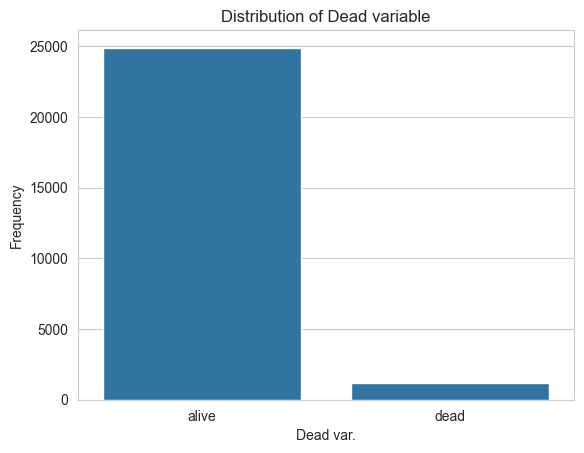

In [67]:
# Check for data imbalance / plot
dead_count = q2_clean_pd.groupby("dead")["dead"].count()
print(dead_count)

sns.barplot(data=dead_count)
plt.xlabel('Dead var.')
plt.ylabel('Frequency')
plt.title('Distribution of Dead variable')
plt.show()

In [68]:
from sklearn.utils import resample

# up-sampling the dataset

q2_df_minority = q2_clean_pd[(q2_clean_pd['dead'] == 'dead')]
q2_df_majority = q2_clean_pd[(q2_clean_pd['dead'] == 'alive')]

q2_df_minority_upsampled = resample(q2_df_minority, replace=True, n_samples=dead_count[0], random_state=42)
q2_df_minority_upsampled.reset_index(drop=True, inplace=True)

q2_df_upsampled = pd.concat([q2_df_minority_upsampled, q2_df_majority])

dead_count2 = q2_df_upsampled.groupby("dead")["dead"].count()
print("==Upsampled dataset count==")
print(dead_count2)

==Upsampled dataset count==
dead
alive    24883
dead     24883
Name: dead, dtype: int64


C:\Users\tommc\AppData\Local\Temp\ipykernel_16896\2119681165.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  q2_df_minority_upsampled = resample(q2_df_minority, replace=True, n_samples=dead_count[0], random_state=42)


## (b) - is Seat Belt var. independent related to the dead var.

Seat Belt is not independent whether the passenger survives or not, this is checked by the chi-square test between the seatbelt and "dead" data.

In [69]:
from scipy.stats import chi2_contingency

table = pd.crosstab(q2_clean_pd['seatbelt'], q2_clean_pd['dead'])
print(table)

# Chi-square test
chi2, p, _, _ = chi2_contingency(table)
print(f"Chi-square Statistic: {chi2}")
print(f"P-value: {p}")

dead      alive  dead
seatbelt             
belted    17965   500
none       6918   680
Chi-square Statistic: 483.7579238069682
P-value: 3.2511305843401275e-107


## (c) - Mean age difference between inj. severity groups

The box plot below shows that there is a significant difference of the mean age between the 5 groups of injury. The difference is more evident with the "Killed" group as more old people are part of this distribution. 

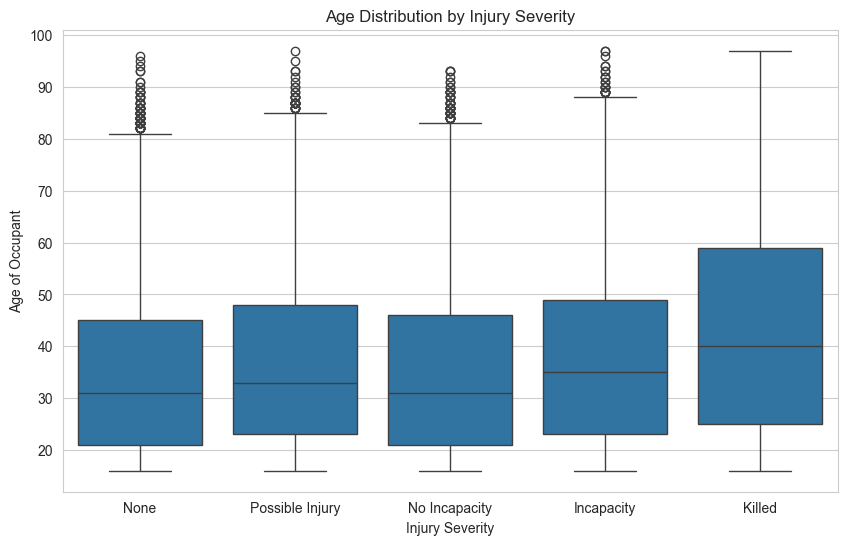

In [70]:
# Box plot visualization
q2_filtered = q2_clean_pd[q2_clean_pd['injSeverity'] < 5]

plt.figure(figsize=(10, 6))
sns.boxplot(x='injSeverity', y='ageOFocc', data=q2_filtered)
plt.title('Age Distribution by Injury Severity')
plt.xlabel('Injury Severity')
plt.ylabel('Age of Occupant')
plt.xticks([0, 1, 2, 3, 4], ['None', 'Possible Injury', 'No Incapacity', 'Incapacity', 'Killed'])
plt.show()

## (d) - GLM for prob. of surviving

The GLM will try to predict the probability of surviving as a function of *airbag*, *seatbelt*, *frontal*, *sex*, *ageOFocc*, *yearVeh*, *deploy* using **70%** to train the model and **30%** of the remaining  data to test it.

The data used to train the model is upsampled to address the imbalance between the two groups we are trying to predict.

Before training the model using 70% of the dataset over dispersion was checked by using the $OD = \frac{\text{pearson's } \chi^2}{\text{Df residuals}}$ and the scale value of the *Quasi-binomial* model.
The test results suggests that there is not enough evidence to show that the model is inadequate.

yearVeh was removed from the final formula for the GLM as it does not contribute enough to the result (P value).

### Comment on GLM model performance

The Binomial GLM model evaluation showed the following results:

- $Accuracy = 0.6812 \approx 68\%$, this means that out of 100 predictions about a person surviving or not a crash, the model correctly predicts only 68 times.
- $Sensitivity = 0.6847 \approx 68\%$, this indicator shows that for every 100 persons that actually survived the crash the model correctly predicts only 68 of them.
- $Specificity = 0.6777 \approx 68\%$, means that for every 100 persons that did not manage to survive the crash the model only correctly identifies 68 of them.

The results shows that the model should be improved to better predict a fatal crash, one possible reason for the low accuracy could be how the prediction, express as a decimal number from 0 to 1 get converted to a nominal value of either 'dead' or 'alive', in this model if the value is $< 0.5$ then the prediction is labeled as 'dead', 'alive' is assigned otherwise. 

In [114]:
# First step - Check for over/under dispersion and define formula

glm_formula = 'dead ~ C(airbag) + C(seatbelt) + C(frontal) + C(sex) + ageOFocc + yearVeh + C(deploy)'

glm_model = glm(formula=glm_formula, data=q2_df_upsampled, family=sm.families.Binomial()).fit()
glm_model_x2 = glm(formula=glm_formula, data=q2_df_upsampled, family=sm.families.Binomial()).fit(scale="X2")

dof = len(glm_model.resid_pearson) - glm_model.df_model - 1 
pearson_over_dispersion = glm_model.pearson_chi2 / dof
print(f"Pearson's chi-2 / Df Residuals: {pearson_over_dispersion}")
print(f"Quasi-binomial model scale: {glm_model_x2.scale}")

glm_model.summary()

Pearson's chi-2 / Df Residuals: 0.9995007958403258
Quasi-binomial model scale: 0.9995007958402727


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Generalized Linear Model Regression Results                       
=========================================================================================
Dep. Variable:     ['dead[alive]', 'dead[dead]']   No. Observations:                49766
Model:                                       GLM   Df Residuals:                    49758
Model Family:                           Binomial   Df Model:                            7
Link Function:                             Logit   Scale:                          1.0000
Method:                                     IRLS   Log-Likelihood:                -29328.
Date:                           Thu, 11 Apr 2024   Deviance:                       58657.
Time:                                   15:44:03   Pearson chi2:                 4.97e+04
No. Iterations:                                4   Pseudo R-squ. (CS):             0.1875
Covariance Type:                       nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.4597      5.142     -0.089      0.929     -10.538       9.619
C(airbag)[T.none]      -1.0109      0.037    -27.157      0.000      -1.084      -0.938
C(seatbelt)[T.none]    -1.3967      0.021    -65.943      0.000      -1.438      -1.355
C(frontal)[T.1]         1.0734      0.022     48.656      0.000       1.030       1.117
C(sex)[T.m]            -0.2770      0.021    -13.453      0.000      -0.317      -0.237
C(deploy)[T.1]         -0.8434      0.032    -26.178      0.000      -0.907      -0.780
ageOFocc               -0.0259      0.001    -49.222      0.000      -0.027      -0.025
yearVeh                 0.0012      0.003      0.475      0.635      -0.004       0.006
=======================================================================================
"""

In [136]:
from sklearn.model_selection import train_test_split

# yearVeh is removed as is not significant
glm_formula2 = 'dead ~ C(airbag) + C(seatbelt) + C(frontal) + C(sex) + ageOFocc + C(deploy)'

# 1- step train / test dataset split
X = q2_df_upsampled[['airbag', 'seatbelt', 'frontal', 'sex', 'ageOFocc', 'deploy']]
y = q2_df_upsampled['dead']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
q2_df_train = pd.concat([X_train, y_train], axis = 1)

glm_eval = glm(formula=glm_formula2, data=q2_df_train, family=sm.families.Binomial()).fit()

# Get the predictions
y_pred = glm_eval.predict(X_test)
y_pred_nominal = np.where(y_pred < 0.5, 'dead', 'alive') # convert predictions to nominal values of either 'dead' or 'alive'

Accuracy: 0.6814
Sensitivity: 0.6846
Specificity: 0.6783


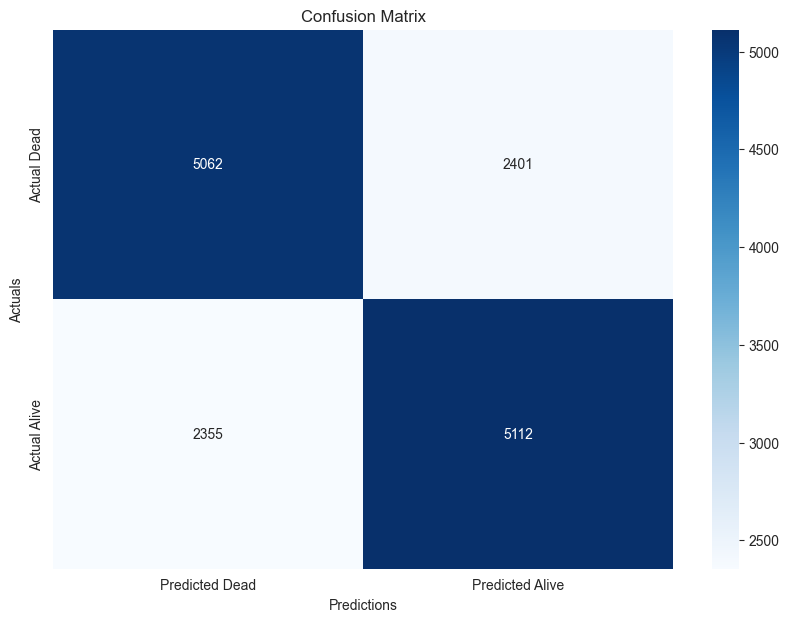

In [137]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Model Evaluation

accuracy = accuracy_score(y_test, y_pred_nominal)
cm = confusion_matrix(y_test, y_pred_nominal)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f'Accuracy: {accuracy:.4f}')
print(f'Sensitivity: {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')

## Visualization
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted Dead', 'Predicted Alive'], yticklabels=['Actual Dead', 'Actual Alive'])
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.title('Confusion Matrix')
plt.show()

## (e) - Interpretation of the seatbelt and ageOFocc parameter

In the trained model the coefficients are:

- $\text{seatbelt(none)} = -1.3971$, the negative parameter tell us that not using a seatbelt significantly decreases the chance to survive a crash. It is also the factor that decreases the probability of surviving the most between the other parameters.
- $\text{ageOFocc} = -0.0262$, this means that an older occupant will slightly decrease the probability of surviving. As the number is very close to zero it means that compared to other parameters like *airbag* or *seatbelt* it will not contribute as much to the outcome of the prediction. 

In [138]:
# Summary of the trained model to consult the coef.
glm_eval.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Generalized Linear Model Regression Results                       
=========================================================================================
Dep. Variable:     ['dead[alive]', 'dead[dead]']   No. Observations:                34836
Model:                                       GLM   Df Residuals:                    34829
Model Family:                           Binomial   Df Model:                            6
Link Function:                             Logit   Scale:                          1.0000
Method:                                     IRLS   Log-Likelihood:                -20489.
Date:                           Thu, 11 Apr 2024   Deviance:                       40978.
Time:                                   16:30:12   Pearson chi2:                 3.48e+04
No. Iterations:                                4   Pseudo R-squ. (CS):             0.1894
Covariance Type:                       nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.0061      0.044     45.931      0.000       1.920       2.092
C(airbag)[T.none]      -1.0378      0.036    -28.830      0.000      -1.108      -0.967
C(seatbelt)[T.none]    -1.3955      0.025    -55.361      0.000      -1.445      -1.346
C(frontal)[T.1]         1.0777      0.026     40.903      0.000       1.026       1.129
C(sex)[T.m]            -0.2951      0.025    -11.991      0.000      -0.343      -0.247
C(deploy)[T.1]         -0.8413      0.038    -21.867      0.000      -0.917      -0.766
ageOFocc               -0.0261      0.001    -41.623      0.000      -0.027      -0.025
=======================================================================================
"""

## (f) - Predictions given a scenario

- Scenario **1**:
For this scenario... 
- Scenario **2**:
In this scenario...

In [140]:
scenarios = pd.DataFrame({
    'airbag': ['none', 'airbag'],
    'seatbelt': ['none', 'belted'],  
    'frontal': [1, 1],
    'sex': ['f', 'f'],        
    'ageOFocc': [70, 70],  
    'deploy': [1, 0]       
})

survival_prob = glm_eval.predict(scenarios)
odds_not_surv = survival_prob / (1 - survival_prob)

for i, odds in enumerate(odds_not_surv, 1):
    print(f"Scenario {i}: Odds of not surviving = {odds:.4f}")

Scenario 1: Odds of not surviving = 0.1325
Scenario 2: Odds of not surviving = 3.5022
